# Visualize Nonlinear Causal Effect

In [1]:
import numpy as np
import pandas as pd

from lingam import RESIT
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from lingam.utils import make_dot, visualize_nonlinear_causal_effect
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

np.random.seed(0)

## Data generation

### Causal Graph

The test data has 5 variables.

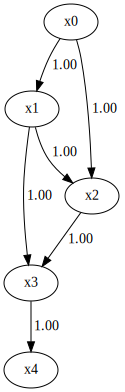

In [2]:
true_graph = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 1, 1, 0, 0],
    [0, 0, 0, 1, 0]
])

make_dot(true_graph)

### Continuous data

There is a nonlinear relationship between variables.

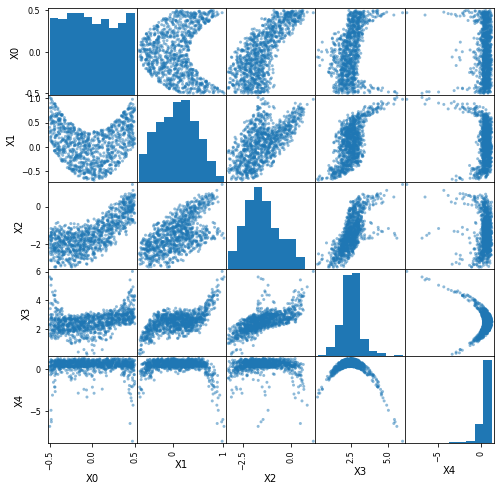

X0    0
X1    0
X2    0
X3    0
X4    0
dtype: int64

In [3]:
n_samples = 1000

def N(size):
    return np.random.uniform(size=size) - 0.5

X = np.zeros([n_samples, 5])
X[:, 0] = N(n_samples)
X[:, 1] = 3 * (X[:, 0] + 0.25) * (X[:, 0] - 0.25) + N(n_samples)
X[:, 2] = -0.75 * (X[:, 0] - 1) * (X[:, 0] - 2) + 1.5 * X[:, 1] + N(n_samples)
X[:, 3] = 5 * (X[:, 1] + 0.4) * (X[:, 1] - 0.1) * (X[:, 1] - 0.5) + 1 * np.log(5 * X[:, 2] + 20) + N(n_samples)
X[:, 4] = -0.8 * (X[:, 3] - 1.5) * (X[:, 3] - 3.5) + N(n_samples)
X = pd.DataFrame(X, columns=[f'X{i}' for i in range(5)])

pd.plotting.scatter_matrix(X, figsize=(8, 8), alpha=0.5)
plt.show()

X.isna().sum()

### Discretizing

X3 of the generated data is discretized and then stored as a separate data frame.

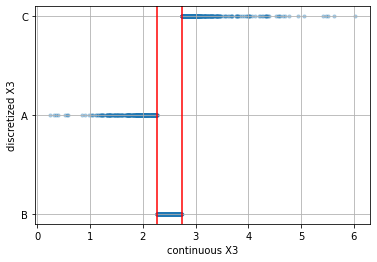

In [4]:
X_discrete = X.copy()

delims = np.percentile(X_discrete["X3"], q=[33, 66])
X_discrete["X3"] = X_discrete["X3"].map(lambda x: sum([delim <= x for delim in delims]))

dict_ = {0: "A", 1: "B", 2: "C"}
X_discrete["X3"] = X_discrete["X3"].apply(lambda e: dict_[e])

X_discrete["X3"] = pd.Categorical(X_discrete["X3"])

plt.scatter(X["X3"], X_discrete["X3"], alpha=0.3, s=10)
plt.axvline(delims[0], color="red")
plt.axvline(delims[1], color="red")
plt.xlabel("continuous X3")
plt.ylabel("discretized X3")
plt.grid()
plt.show()

## Causal discovery

A nonlinear causal discovery is performed and the bootstrap results are returned.

In [5]:
regressor = RandomForestRegressor()
model = RESIT(regressor=regressor, alpha=1)
bs_result = model.bootstrap(X, n_sampling=100)

## Visualization of nonlinear causal effect

### Continuous data

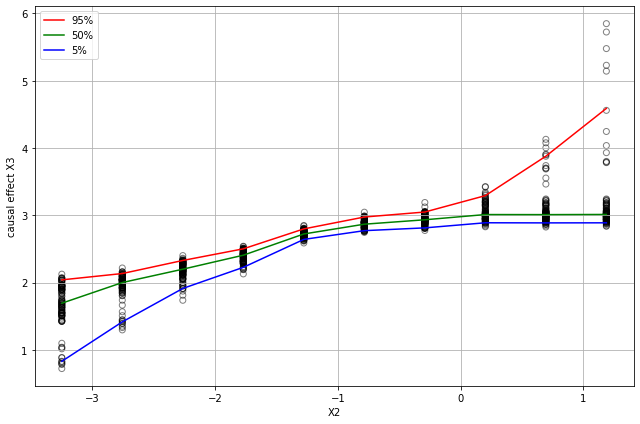

In [6]:
fig = plt.figure(figsize=(9, 6))

fig = visualize_nonlinear_causal_effect(X, bs_result, RandomForestRegressor(), "X2", "X3", fig=fig)

for ax in fig.get_axes():
    ax.legend()
    ax.grid()

fig.tight_layout()
fig.show()

It is also possible to give optional arguments for the arguments.

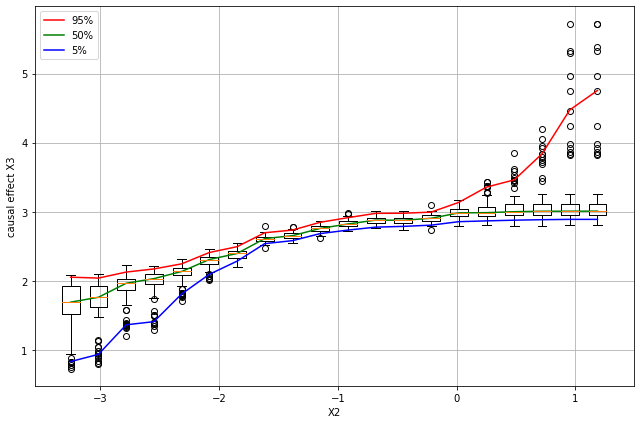

In [7]:
fig = plt.figure(figsize=(9, 6))

cause_positions = np.linspace(X["X2"].min(), X["X2"].max(), 20)

fig = visualize_nonlinear_causal_effect(X, bs_result, RandomForestRegressor(), "X2", "X3", fig=fig, cause_positions=cause_positions, boxplot=True)

for ax in fig.get_axes():
    ax.legend()
    ax.grid()

fig.tight_layout()
fig.show()

### Discrete data

If `effect_name` is a discrete variable, the probability of belonging to each class is displayed as a causal effect.

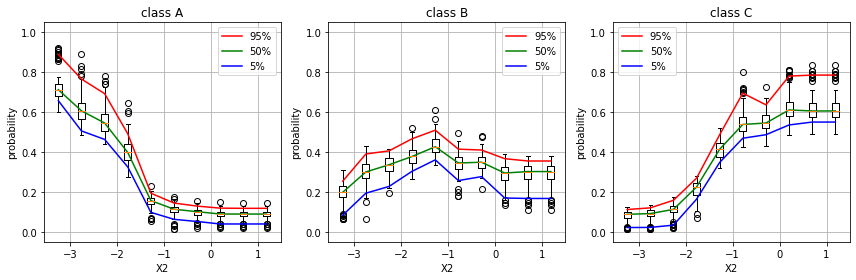

In [8]:
fig = plt.figure(figsize=(12, 4))

fig = visualize_nonlinear_causal_effect(X_discrete, bs_result, RandomForestClassifier(), "X2", "X3", fig=fig, boxplot=True)

for ax in fig.get_axes():
    ax.legend()
    ax.grid()

fig.tight_layout()
fig.show()

## Visualization of predictions based on a single adjacency matrix

It is also possible to visualize predictions based on a single adjacency matrix rather than bootstrap results. Here, we used the true graph as a adjacency matrix.

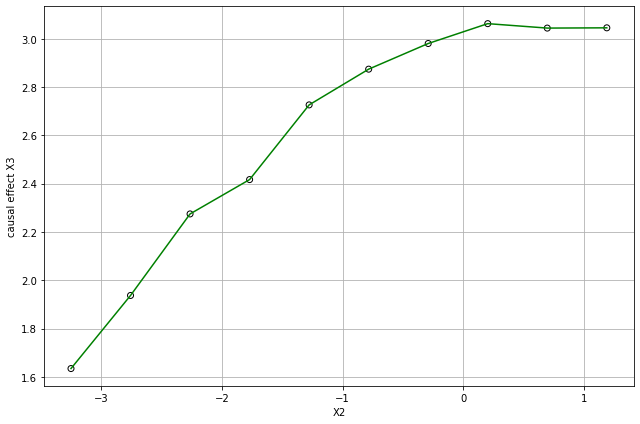

In [9]:
fig = plt.figure(figsize=(9, 6))

fig = visualize_nonlinear_causal_effect(X, true_graph, RandomForestRegressor(), "X2", "X3", fig=fig)

for ax in fig.get_axes():
    ax.grid()

fig.tight_layout()
fig.show()

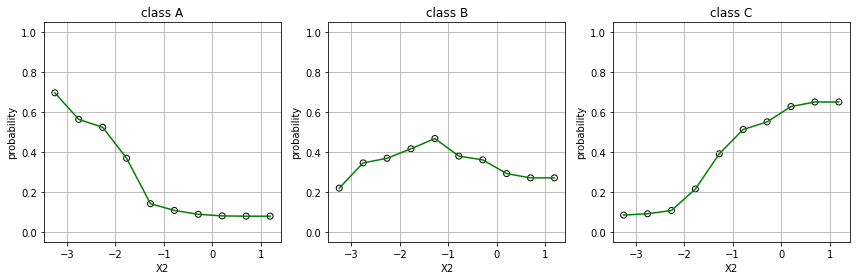

In [10]:
fig = plt.figure(figsize=(12, 4))

fig = visualize_nonlinear_causal_effect(X_discrete, true_graph, RandomForestClassifier(), "X2", "X3", fig=fig)

for ax in fig.get_axes():
    ax.grid()

fig.tight_layout()
fig.show()